In [2]:
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, GlobalMaxPooling2D, MaxPooling2D, Conv2D, GlobalAveragePooling2D 
from numpy import array
from keras import optimizers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
import keras.applications
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from os.path import isfile, join
from os import listdir
import os, os.path
import shutil
from random import shuffle
from shutil import copyfile
%matplotlib inline
from keras.callbacks import ModelCheckpoint
import cv2
import sys
import tensorflow as tf

In [4]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range=0.2,
        zoom_range=0.2,     
        rotation_range=15,
        width_shift_range=.15,
        height_shift_range=.15)
test_datagen = ImageDataGenerator(rescale=1./255)
train_path = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_train"
valid_path = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_valid"
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=24,
        class_mode='categorical',
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        valid_path,
        target_size=(224, 224),
        batch_size=24,
        class_mode='categorical',
        shuffle = False)   

Found 86971 images belonging to 29 classes.
Found 37729 images belonging to 29 classes.


In [3]:
sys.path.append("/work/keras_model/")

from resnet152_keras import resnet152_model
with tf.device('/device:GPU:0'):
    base_model = resnet152_model(weights_path="/work/resnet152_weights_tf.h5",classes=29)

x = base_model.output

model = Model(base_model.input, x, name="asl_model")
model.summary()
for layer in model.layers:
    layer.trainable = True


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

res4b26_branch2b_zeropadding (Z (None, 16, 16, 256)  0           res4b26_branch2a_relu[0][0]      
__________________________________________________________________________________________________
res4b26_branch2b (Conv2D)       (None, 14, 14, 256)  589824      res4b26_branch2b_zeropadding[0][0
__________________________________________________________________________________________________
bn4b26_branch2b (BatchNormaliza (None, 14, 14, 256)  1024        res4b26_branch2b[0][0]           
__________________________________________________________________________________________________
scale4b26_branch2b (Scale)      (None, 14, 14, 256)  512         bn4b26_branch2b[0][0]            
__________________________________________________________________________________________________
res4b26_branch2b_relu (Activati (None, 14, 14, 256)  0           scale4b26_branch2b[0][0]         
__________________________________________________________________________________________________
res4b26_br

In [4]:
sgd = keras.optimizers.SGD(lr = 0.01,momentum=0.0, decay = 1e-4,nesterov = True)

model.compile(optimizer = sgd,
            loss="categorical_crossentropy",
            metrics=["accuracy"])
#checkpointer = ModelCheckpoint(filepath = "/home/t-judai/log_asl201.{epoch:02d}-{val_acc:.2f}.hdf5", monitor = "val_acc", verbose = 1, save_best_only = True, mode = "auto")
history = model.fit_generator(
        train_generator,
        steps_per_epoch=3600,
        epochs=10,
        validation_data = validation_generator,
        validation_steps=1500,
        verbose = 1,
        )

Epoch 1/10
3600/3600 [==============================] - 8461s 2s/step - loss: 0.0995 - acc: 0.9736 - val_loss: 0.1178 - val_acc: 0.9724
Epoch 2/10
3600/3600 [==============================] - 8438s 2s/step - loss: 0.0124 - acc: 0.9966 - val_loss: 0.0763 - val_acc: 0.9829
Epoch 3/10
3600/3600 [==============================] - 8429s 2s/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.0772 - val_acc: 0.9825
Epoch 4/10
3600/3600 [==============================] - 8471s 2s/step - loss: 0.0060 - acc: 0.9983 - val_loss: 0.0845 - val_acc: 0.9822
Epoch 5/10
3600/3600 [==============================] - 8423s 2s/step - loss: 0.0049 - acc: 0.9987 - val_loss: 0.0737 - val_acc: 0.9848
Epoch 6/10
3600/3600 [==============================] - 8426s 2s/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0714 - val_acc: 0.9857
Epoch 7/10
3600/3600 [==============================] - 8425s 2s/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.0765 - val_acc: 0.9851
Epoch 8/10
3600/3600 [==========================

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


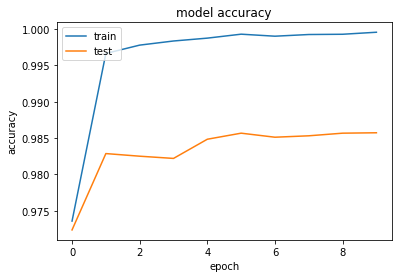

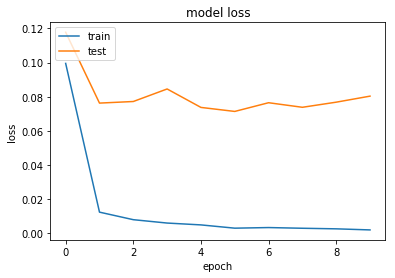

In [5]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
def separateData(data_dir):
    for filename in listdir(data_dir):
        if isfile(join(data_dir, filename)):
            tokens = filename.split('.')
            if tokens[-1] == 'jpg':
                image_path = join(data_dir, filename)
                if not os.path.exists(join(data_dir, tokens[0])):
                    os.makedirs(join(data_dir, tokens[0]))
                copyfile(image_path, join(join(data_dir, tokens[0]), filename))
                os.remove(image_path)
#separateData("/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_test")
def plots(ims, figsize=(12,6), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
#test_imgs, test_labels = next(test_generator)
#plots (test_imgs, titles = test_labels)

#score = model.evaluate_generator(test_generator)
#print (score)

'img = "/work/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_predict/space4.jpg"\nfile = load_img(img,target_size = (224, 224))\nnumpy_file = img_to_array(file)\nfinal_file = numpy.expand_dims(numpy_file, axis = 0)\nplt.imshow(np.uint8(final_file[0]))\ny_prob = model.predict(final_file/255)\ny_classes = y_prob.argmax(axis=-1)\n\nprint (y_prob)\nprint (y_classes)'

In [8]:
model.save("/work/8_6_18_resnet152.hdf5")

In [9]:
from sklearn import metrics

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1]= 12
    plt.rcParams["figure.figsize"] = fig_size

In [11]:
import itertools
classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "del", "nothing", "space"]
res = model.predict_generator(validation_generator, verbose = 1)


1573/1573 [==============================] - 1077s 685ms/step


Confusion matrix, without normalization
[[1299    0    0    0    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0 1299    0    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0 1301    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0 1298    0    0    0    0    0    0    0    0    0    0
     1    0    0    2    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0 1286    0    0    0    0    0    0    0    0    0
     0    0    0    0   15    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0 1301    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0 1301    0    0  

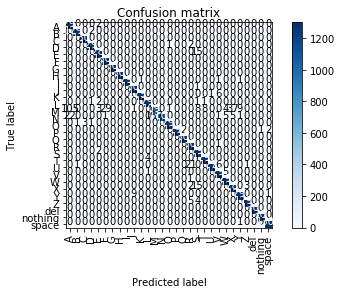

In [12]:
import sklearn
pred = np.argmax(res, axis = 1)
matrix = sklearn.metrics.confusion_matrix(validation_generator.classes, pred)
plot_confusion_matrix(matrix, classes, normalize=False)

In [40]:
predict_path = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_predict"
prediction_generator = train_datagen.flow_from_directory(
        predict_path,
        target_size=(224, 224),
        batch_size=24,
        class_mode='categorical',
        shuffle = False)   
test_path = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/asl_alphabet_test"
test_generator = train_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=24,
        class_mode='categorical',
        shuffle = False) 

Found 9268 images belonging to 29 classes.
Found 116 images belonging to 29 classes.


5/5 [==============================] - 6s 1s/step
Confusion matrix, without normalization
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 

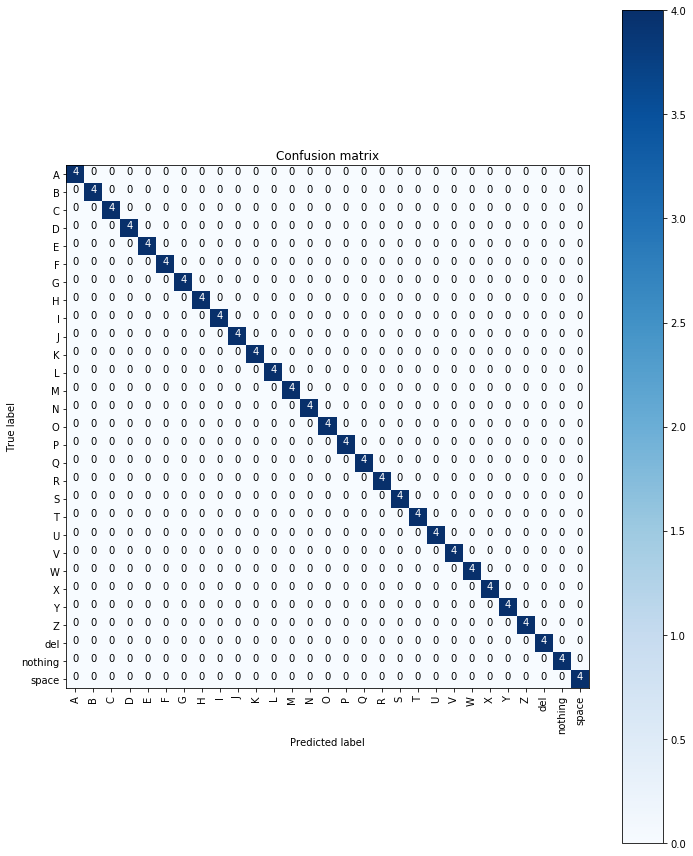

In [41]:
res = model.predict_generator(test_generator, verbose = 1)
pred = np.argmax(res, axis = 1)
matrix = sklearn.metrics.confusion_matrix(test_generator.classes, pred)
plot_confusion_matrix(matrix, classes, normalize=False)

In [4]:
from keras.models import load_model
model.load_weights("/work/8_6_18_resnet152.hdf5")

[[7.6263246e-10 4.5708397e-09 1.0683585e-06 9.9999487e-01 3.4780065e-10
  3.3258328e-07 5.6865957e-08 5.8947323e-09 9.5896544e-09 9.3879092e-11
  1.6799802e-06 1.8652825e-06 1.0642101e-09 9.8076516e-09 3.2716969e-08
  4.0593764e-09 1.0324499e-09 4.1546155e-11 2.9382816e-10 8.1151412e-11
  6.5427948e-09 2.0216433e-09 1.0206653e-08 6.9422748e-09 6.8236576e-11
  1.9442222e-08 1.8901380e-09 1.4342551e-08 5.7065719e-10]]
D


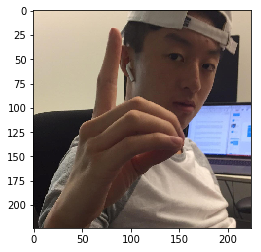

In [6]:
from PIL import Image
from keras.preprocessing import image
import tensorflow as tf
import numpy
img = "/home/t-judai/kaggle-link/datasets/grassknoted/asl-alphabet/temp/D_william.jpg"
file = tf.keras.preprocessing.image.load_img(img,target_size = (224, 224))
numpy_file = tf.keras.preprocessing.image.img_to_array(file)
final_file = numpy.expand_dims(numpy_file, axis = 0)
plt.imshow(np.uint8(final_file[0]))
y_prob = model.predict(final_file/255)
y_classes = y_prob.argmax(axis=-1)
alphabet = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "del", "nothing", "space"]

print (y_prob)
print (alphabet[int(y_classes)])